# Problem

This dataset is a record of 7 common different fish species in fish market sales. We want a model to estimate a fish's weight. 

https://www.kaggle.com/aungpyaeap/fish-market

# Summary of Results

Linear regression performed with an r2 score of `0.975` on the test set while fairly well satisfying the assumptions of an OLS estimator.

***

In [1]:
!pip install kaggle

In [2]:
!pip install sklearn2pmml

In [3]:
!pip install mlxtend

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import kaggle

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

sns.set_theme(style="darkgrid")
%matplotlib inline

# Exploratory Data Analysis

In [5]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('aungpyaeap/fish-market', path='data/', unzip=True)

## Data Dictionary

* Species: Species name of fish
* Weight: Weight of fish in gram
* Length1: Vertical length in cm
* Length2: Diagonal length in cm
* Length3: Cross length in cm
* Height: Height in cm
* Width: Diagonal width in cm

In [6]:
data = pd.read_csv('./data/Fish.csv')

## Overview

First, we gather basic impressions and answer basic questions abou the data like,

* What do some sample values look like?
* How many rows are there and what are their types?

In [7]:
data.sample(frac=.1).head(10)

,Species,Weight,Length1,Length2,Length3,Height,Width
107,Perch,300.0,26.9,28.7,30.1,7.5852,4.6354
104,Perch,265.0,25.4,27.5,28.9,7.0516,4.3350
132,Pike,430.0,35.5,38.0,40.5,7.2900,4.5765
141,Pike,1250.0,52.0,56.0,59.7,10.6863,6.9849
131,Pike,300.0,34.8,37.3,39.8,6.2884,4.0198
32,Bream,925.0,36.2,39.5,45.3,18.7542,6.7497
34,Bream,950.0,38.0,41.0,46.5,17.6235,6.3705
36,Roach,69.0,16.5,18.2,20.3,5.2983,2.8217
72,Perch,5.9,7.5,8.4,8.8,2.1120,1.4080
38,Roach,87.0,18.2,19.8,22.2,5.6166,3.1746


In [8]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Weight,159.0,398.326415,357.978317,0.0000,120.00000,273.0000,650.0000,1650.000
Length1,159.0,26.247170,9.996441,7.5000,19.05000,25.2000,32.7000,59.000
Length2,159.0,28.415723,10.716328,8.4000,21.00000,27.3000,35.5000,63.400
Length3,159.0,31.227044,11.610246,8.8000,23.15000,29.4000,39.6500,68.000
Height,159.0,8.970994,4.286208,1.7284,5.94480,7.7860,12.3659,18.957
Width,159.0,4.417486,1.685804,1.0476,3.38565,4.2485,5.5845,8.142


## Data Quality

* Is there missing data?
* Are columns the right types?
* Are there outliers in any of the columns? Consider uni-variate and multi-variate analysis. 

#### *Is there missing data?*

In [10]:
print(str('Are there any missing values in the dataset?'), data.isnull().values.any())

Are there any missing values in the dataset? False


#### *Are columns the right types?*

In [11]:
pd.DataFrame(data['Species'].value_counts()).T

,Perch,Bream,Roach,Pike,Smelt,Parkki,Whitefish
Species,56,35,20,17,14,11,6


We can see from the data type displayed in the overview section and the data above that the `Species` columns is categorical.

In [12]:
 data['Species'] = data['Species'].astype('category')

#### *Are there outliers in any of the columns?*

**Univariate Analysis** 

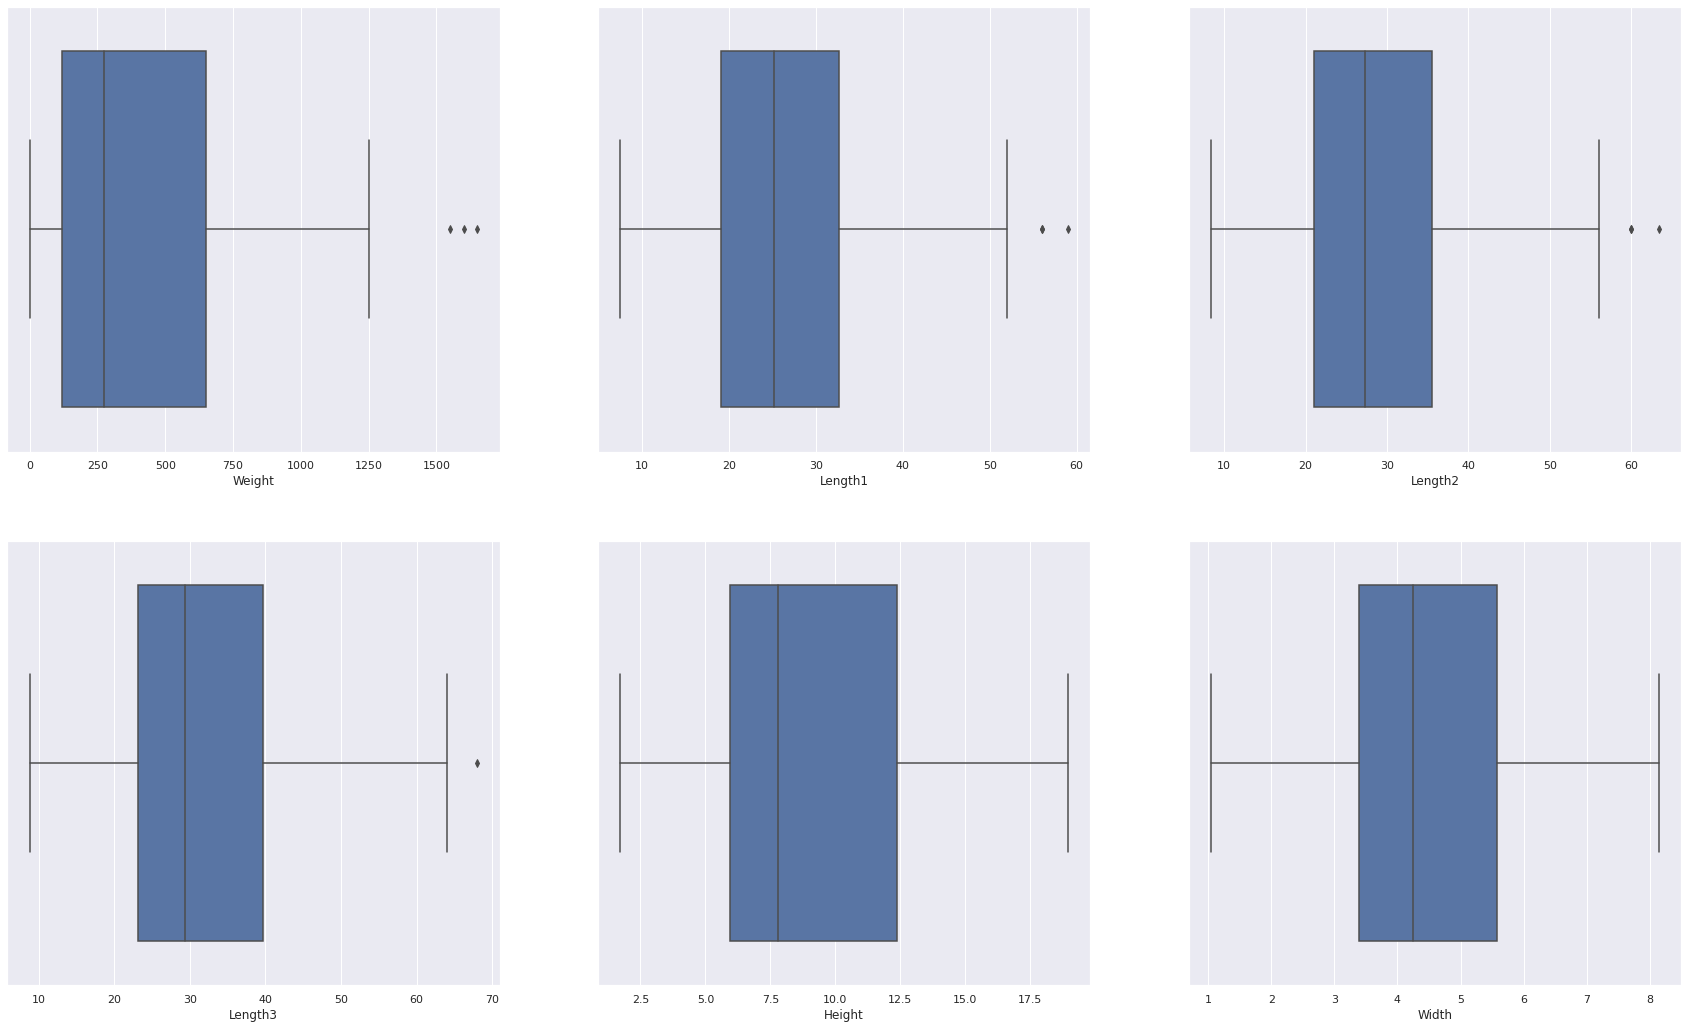

In [13]:
boxplot_fields = ['Weight','Length1','Length2','Length3','Height','Width']
fig, ax = plt.subplots(2, 3, figsize=(30, 18))
for var, subplot in zip(boxplot_fields, ax.flatten()):
    sns.boxplot(x=var, data=data, ax=subplot)

**Multi-Variate Analysis**

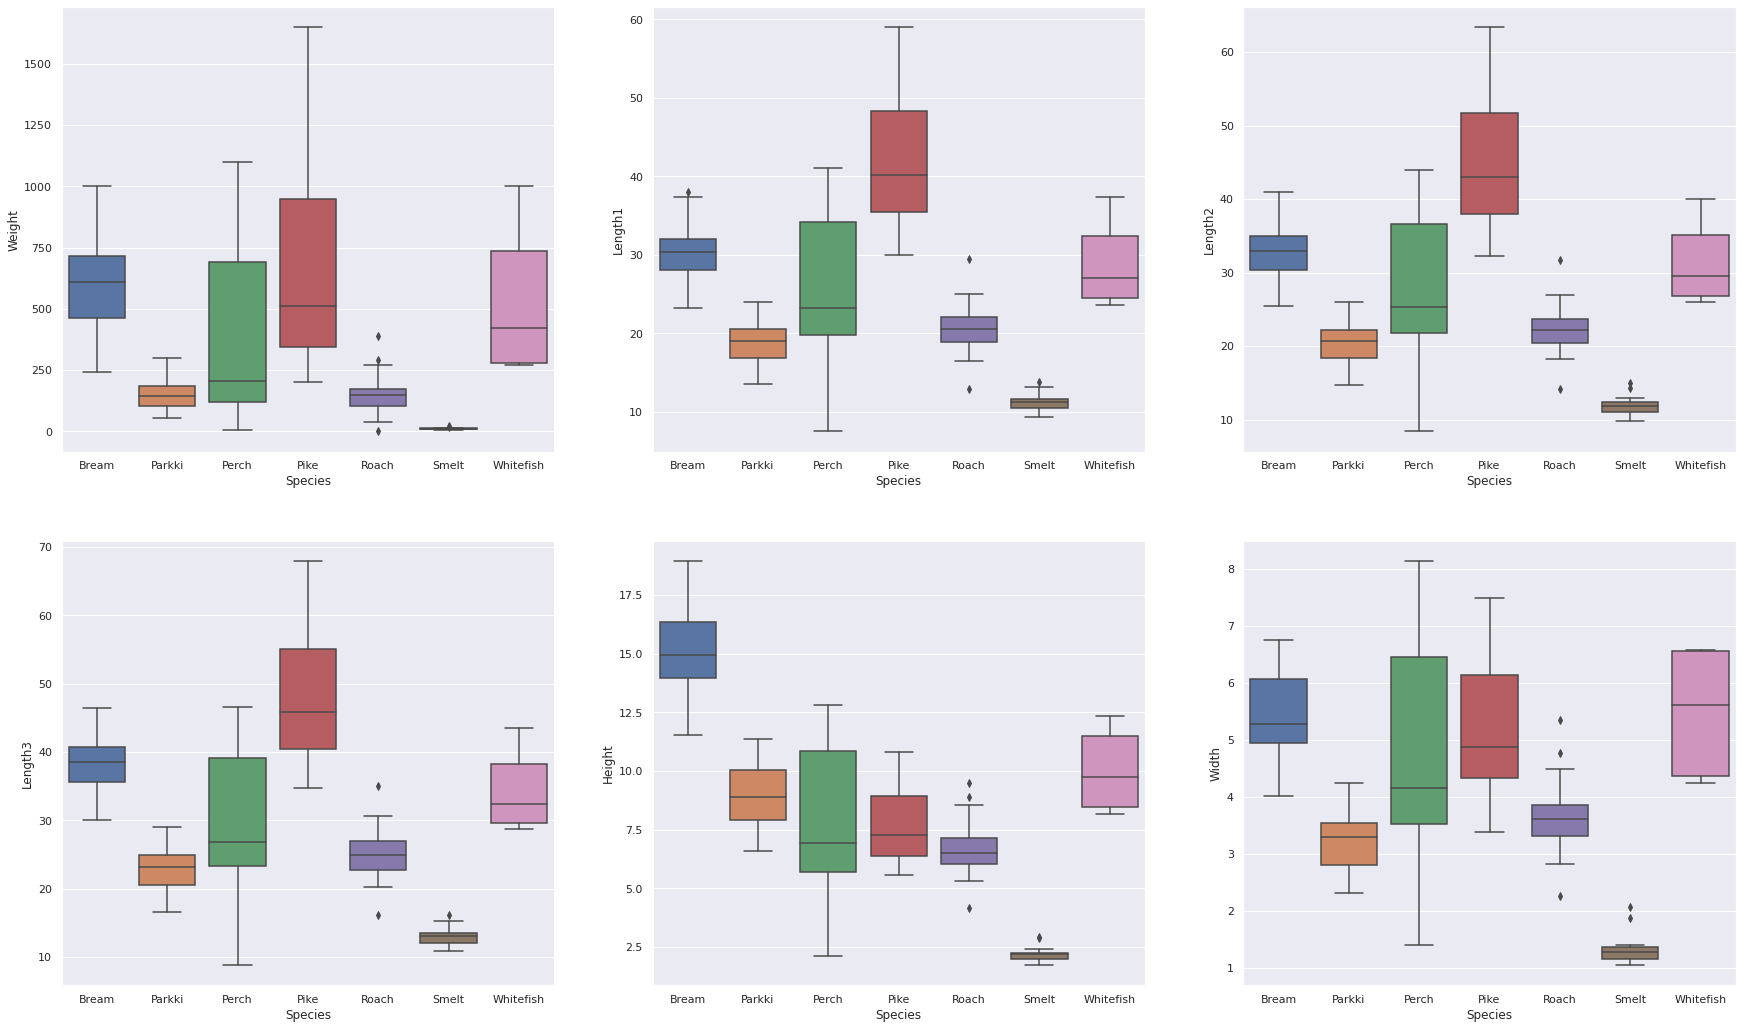

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(30, 18))
for var, subplot in zip(boxplot_fields, ax.flatten()):
    sns.boxplot(x='Species', y=var, data=data, ax=subplot)

*Observations*
* The distributions of most of the features by species are skewed left or right. 
* From the multi-variate analysis above it's very likely we will want to include species as a predictor. 
* The outliers that exist per feature in the univariate analysis are not all the same ones that exist in the multivariate analysis by species.

**Remove Outliers by Feature**

In [37]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

lowerend = 0 # This would otherwise be Q1[c] - (1.5 * IQR[c]) but negative values don't make sense for the variables.
upperend = Q3 + (1.5 * IQR)

for c in boxplot_fields:
    print(c + ':')
    upperend = Q3[c] + (1.5 * IQR[c])
    feature = data[c]
    outliers = feature[(feature <= lowerend) | (feature > upperend)]
    print(outliers)

Weight:
40        0.0
142    1600.0
143    1550.0
144    1650.0
Name: Weight, dtype: float64
Length1:
142    56.0
143    56.0
144    59.0
Name: Length1, dtype: float64
Length2:
142    60.0
143    60.0
144    63.4
Name: Length2, dtype: float64
Length3:
144    68.0
Name: Length3, dtype: float64
Height:
Series([], Name: Height, dtype: float64)
Width:
Series([], Name: Width, dtype: float64)


In [38]:
fishes = data.copy()
fishes = fishes[~((fishes[boxplot_fields] <= 0) | (fishes[boxplot_fields] > (Q3 + 1.5 * IQR))).any(axis=1)]

## Graphical Exploration

#### Distributional Observations

An early step in any effort to analyze or model data is understanding how the variables are distributed.

* What range do the observations cover? 
* What is their central tendency? 
* Are they heavily skewed in one direction? 
* Is there evidence for bimodality? 
* Are there significant outliers? 
* Do the answers to these questions vary across subsets defined by other variables?
* Is the response variable imbalanced?

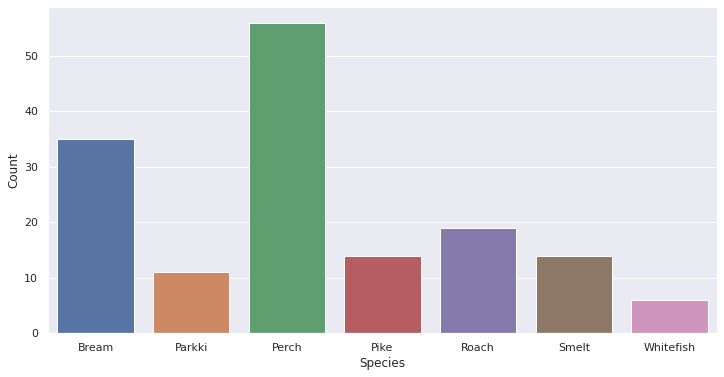

In [39]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x="Species", data=fishes);
ax.set_ylabel("Count")
plt.show()

*Observations*
* If the response variable were `Species` then this plot would tell use that we have an imbalanced dataset.

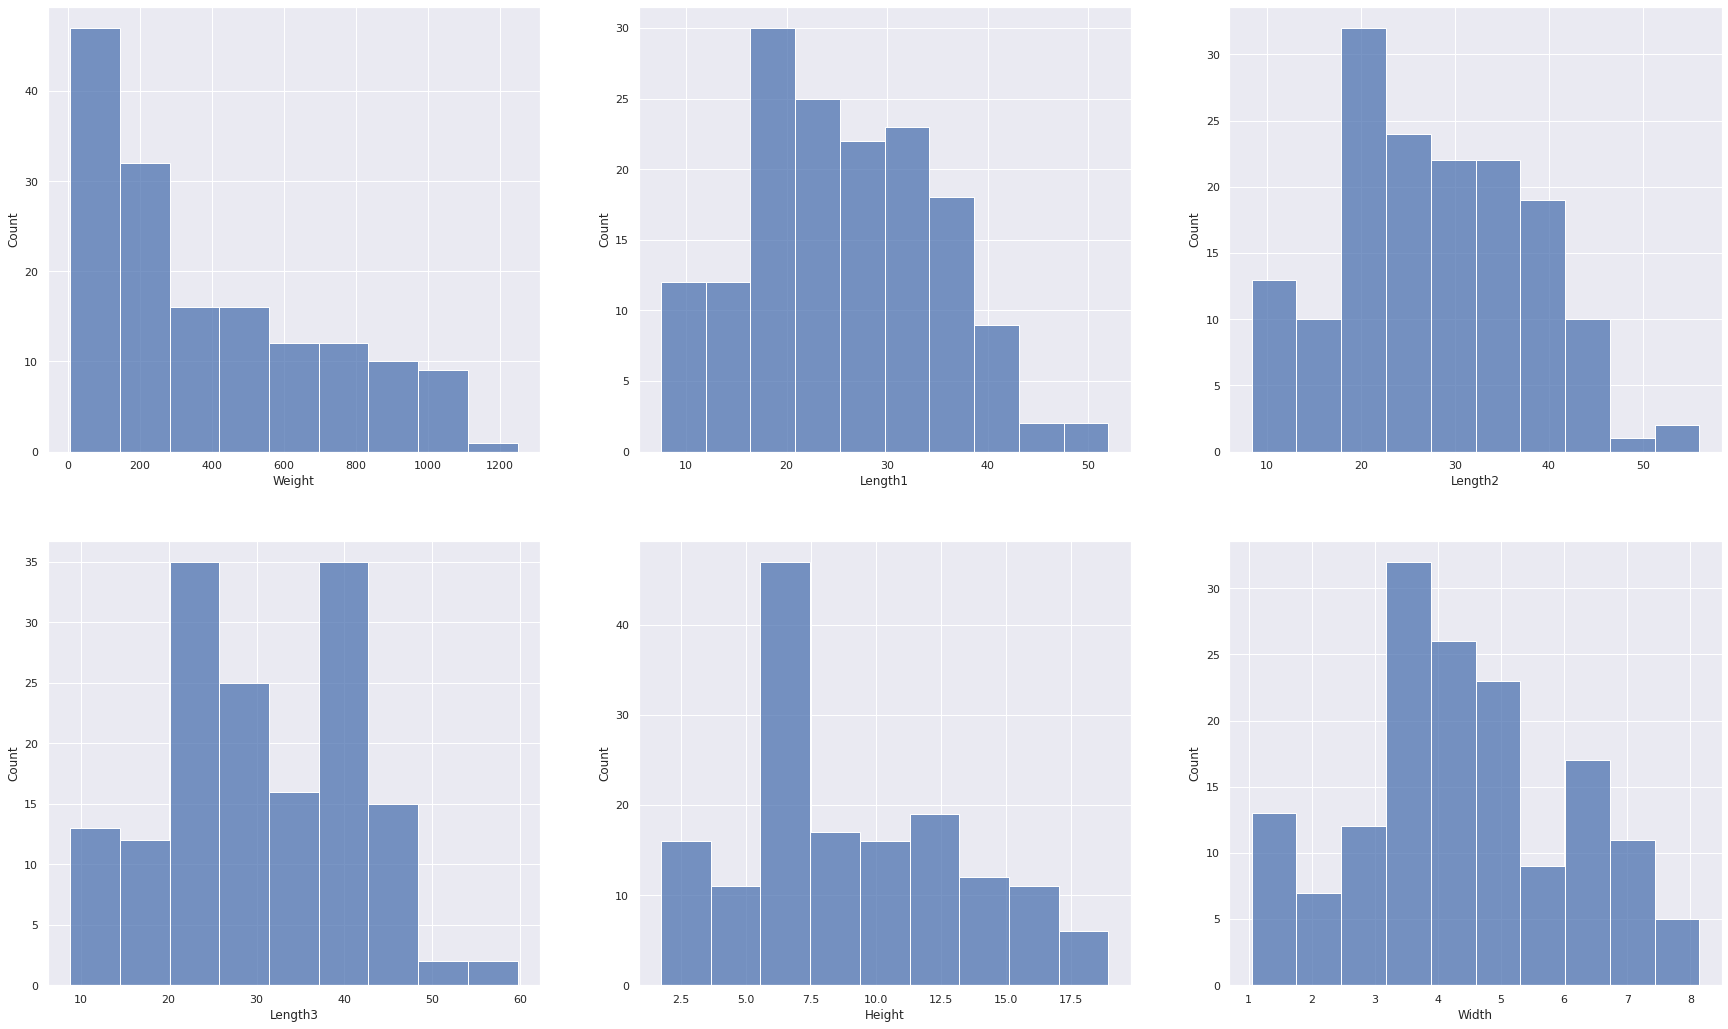

In [40]:
columns_for_hist = ['Weight','Length1','Length2','Length3','Height','Width']
fig, ax = plt.subplots(2, 3, squeeze=True, figsize=(30, 18))
for col, subplot in zip(columns_for_hist, ax.flatten()):
    sns.histplot(fishes, x=col, ax=subplot);

*Observations*
* Length[1,2,3] have nearly identical distributions, which identifies them as probably multicolinear. Thus not all of these potential predictors should be included in a linear model.
* Weight resembles a log normal distribution so transforming that would be worth trying in a our model

#### Relationships

First I'll explore correlations. In statistical terms, correlation is a method of assessing a possible two-way linear association between two continuous variables. 

**Pearson's Correlation**

The Pearson product-moment correlation attempts to draw a line of best fit through the data of two variables. The Pearson correlation coefficient, *r*, indicates how far away all these data points are to this line of best fit (i.e., how well the data points fit this new model/line of best fit). The key assumptions of using this statistic are,

* Both variables being studied are normally distributed
* This coefficient is affected by extreme values, which may exaggerate or dampen the strength of relationship, and is therefore inappropriate when either or both variables are not normally distributed.

The condition of normal distribution isn't well satisfied from what we can see in the histograms above, but I examine the values for the purposes of understanding our problem.

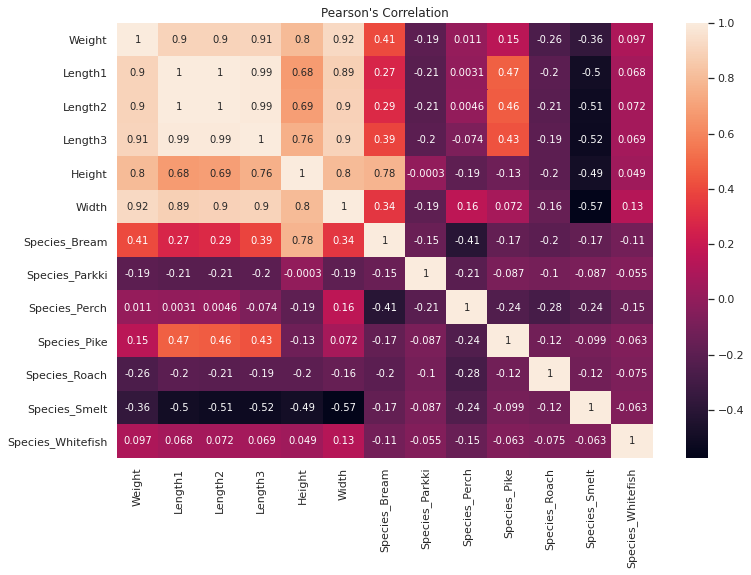

In [41]:
plt.figure(figsize=(12,8))
plt.title("Pearson's Correlation")
sns.heatmap(pd.get_dummies(fishes).corr(), annot=True);
plt.show();

*Observations*
* The response variable, Weight, is highly correlated with all of the other numerical features, which is an indication of high multicolinearity. Although, not definitely.

**Spearmen's Correlation**



The key assumptions of using this statistic are,

* It is appropriate when one or both variables are skewed or ordinal1 and is robust when extreme values are present.

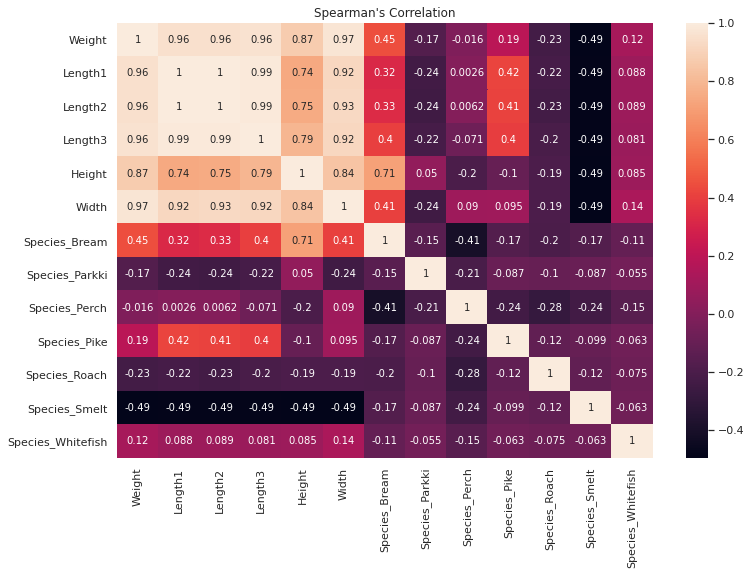

In [42]:
plt.figure(figsize=(12,8))
plt.title("Spearman's Correlation")
sns.heatmap(pd.get_dummies(fishes).corr(method='spearman'), annot=True);
plt.show();

*Observations*
* In contrast to Pearson's correlation we see that highest correlation of `Weight` between `Width` and any of `Length[1,2,3]`, but all features show high correlation coefficents. 
* Features `Length[1,2,3]` are highly colinear 

Lastly, I examine the relationships amongst the variables using a scatter plot.

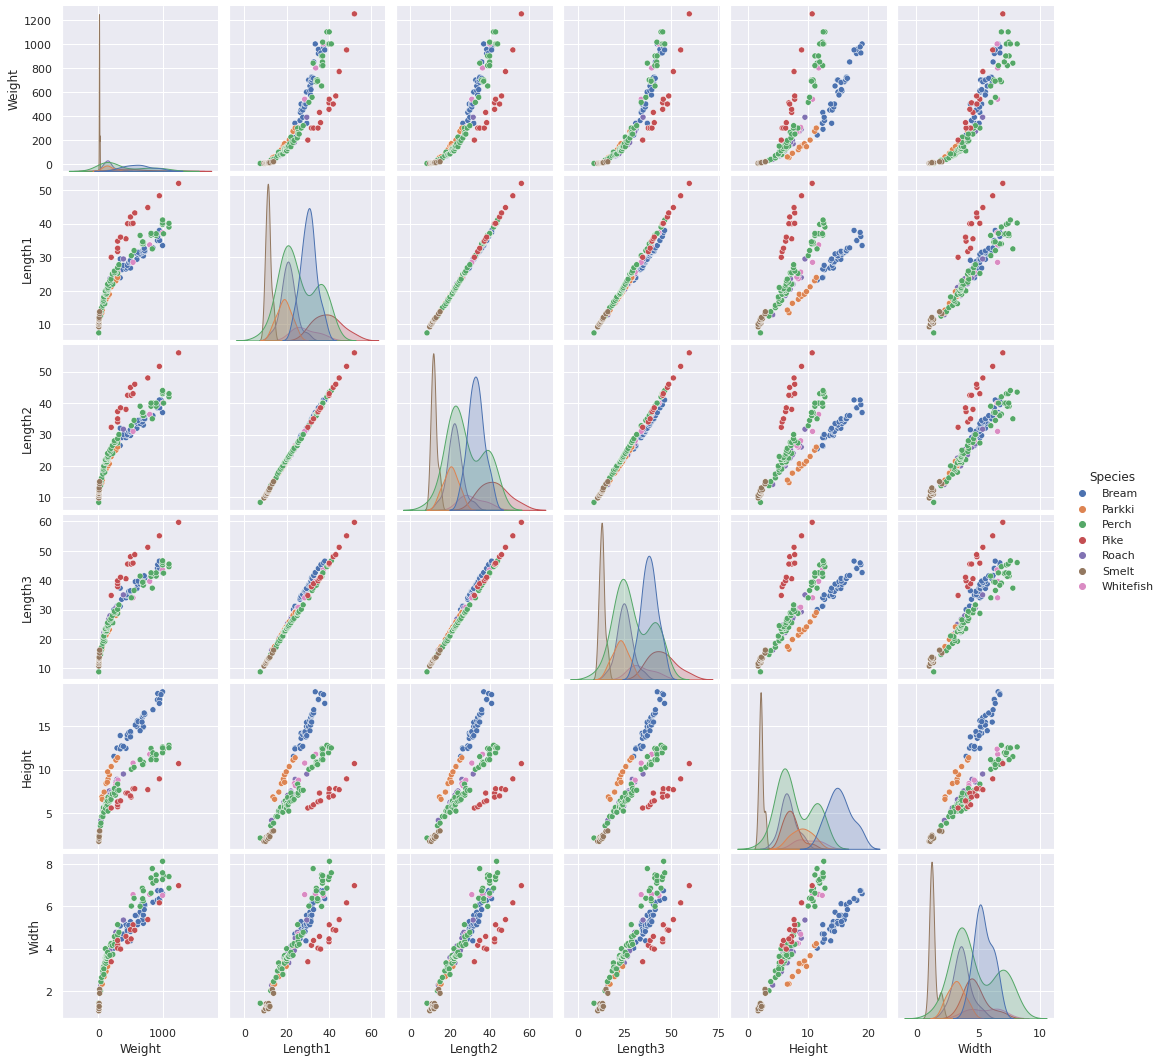

In [43]:
g = sns.pairplot(fishes, kind='scatter', hue='Species');

*Observations*

* There continues to be strong linear relationships between our response variable, `Weight`, and all the features generally.
* There are strong linear relationships between `Weight` and each of the features by `Species`.

# The Model

We saw from Spearmen's correlation and the pair plot above that there are strong linear relationships betweeen `Weight` and serveral of the other variables. 

**Using Statsmodel**

In [17]:
from statsmodels.formula.api import ols

train, test = train_test_split(fishes, test_size=0.3, random_state=1)

mod = ols(formula='np.log(Weight) ~ np.log(Length3) + C(Species)', data=train)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(Weight)   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1811.
Date:                Wed, 02 Jun 2021   Prob (F-statistic):          2.73e-102
Time:                        05:27:59   Log-Likelihood:                 85.421
No. Observations:                 108   AIC:                            -154.8
Df Residuals:                     100   BIC:                            -133.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -5.1206      0.176    -29.028      0.000      -5.471      -4.771
C(Species)[T.Parkki]        0.2314      0.051      4.516      0.000       0.130       0.333
C(Species)[T.Perch]         0.1092      0.033      3.348      0.001       0.045       0.174
C(Species)[T.Pike]         -0.6971      0.042    -16.570      0.000      -0.781      -0.614
C(Species)[T.Roach]        -0.0489      0.044     -1.120      0.265      -0.136       0.038
C(Species)[T.Smelt]        -0.5909      0.069     -8.530      0.000      -0.728      -0.453
C(Species)[T.Whitefish]     0.2059      0.084      2.448      0.016       0.039       0.373
np.log(Length3)             3.1460      0.048     65.162      0.000       3.050       3.242
==============================================================================
Omnibus:                        9.917   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               24.159
Skew:                           0.067   Prob(JB):                     5.67e-06
Kurtosis:                       5.313   Cond. No.                         63.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The following models were also tried, but I found they didn't score as well or violated the assumptions of linear models to a degree that didn't justify their use.
* Weight ~ Width
* Weight ~ Height * Width * Length1
* Weight ~ (Height * Width * Length1) + C(Species)
* np.log(Weight) ~ np.log(Height) * np.log(Length1) * np.log(Width) + C(Species)
* np.log(Weight) ~ np.log(Height) + np.log(Length1) + np.log(Width) + C(Species)

*Test Set Performance*

In [18]:
X_test = test.drop(columns=['Weight'])
y_test = test['Weight']
y_pred = np.exp(res.predict(X_test))

In [19]:
print('Coefficient of determination: %.3f' % r2_score(y_test, y_pred))

Coefficient of determination: 0.975


In [20]:
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

Mean squared error: 3254.71


### Validate Assumptions of Linear Regression

Let's make sure it's clear why we have to evaluate any regression model that we formulate and subsequently estimate. In short, it's because:

* All of the estimates, intervals, and hypothesis tests arising in a regression analysis have been developed assuming that the model is correct. That is, all the formulas depend on the model being correct!
* If the model is incorrect, then the formulas and methods we use are at risk of being incorrect.

The four conditions ("LINE") that comprise the simple linear regression model are:

* The mean of the response , E(Yi), at each set of values of the predictors, (x1i,x2i,…), is a Linear function of the predictors.
* The errors, εi, are Independent.
* The errors, εi, at each set of values of the predictors, (x1i,x2i,…), are Normally distributed.
* The errors, εi, at each set of values of the predictors, (x1i,x2i,…), have Equal variances (denoted σ2).

An alternative way to describe all four assumptions is that the errors, ϵi, are independent normal random variables with mean zero and constant variance, σ2.

*Validate Linearity*

We can inspect a pair plot to observe the linear relationships between the response (Weight) and the predictors.

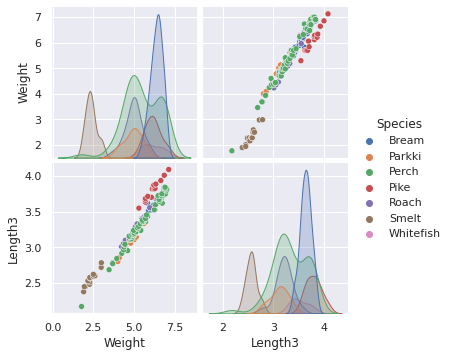

In [22]:
predictors = fishes.copy().filter(items=['Weight', 'Length3', 'Species'])
predictors['Weight'] = np.log(predictors['Weight'])
predictors['Length3'] = np.log(predictors['Length3'])

sns.pairplot(predictors, kind='scatter', hue='Species');

*Residuals Normally Distributed*

The qualtile-quantile (Q-Q) plot provides a handy visual means to inspect the similarity of distributions of a data set. The idea is to plot the quantiles of the sample on the vertical axis and the quantiles of a theoretical distribution on the horizontal axis. If the points of the plot fall on an approximately straight line, you can conclude that the sample distribution is close to the thoretical.

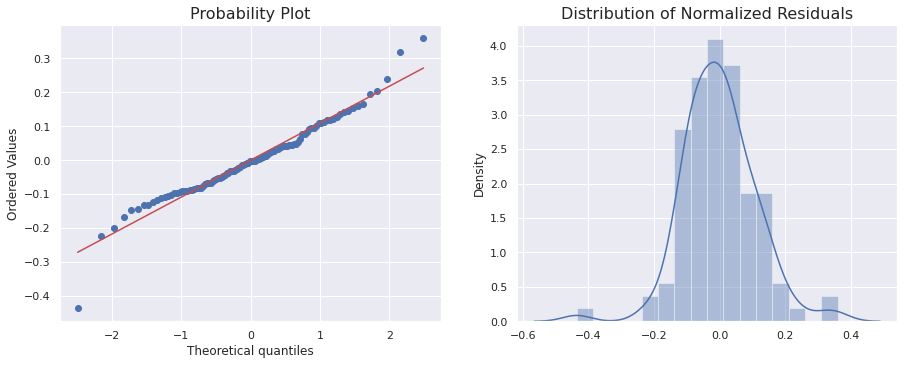

In [36]:
from scipy import stats

plt.subplots(figsize=(15, 12))
ax1 = plt.subplot(221) 
stats.probplot(res.resid, plot=ax1)
ax1.set_title('Probability Plot', fontsize=16)
ax1 = plt.subplot(222) 
sns.distplot(res.resid, ax=ax1)
ax1.set_title('Distribution of Normalized Residuals', fontsize=16)
plt.show()

Next we apply a formal method. The Anderson-Darling test for normal distribution unknown mean and variance. Passing the normality test only allows you to state no significant departure from normality was found.

In [24]:
from statsmodels.stats.diagnostic import normal_ad

p_value = normal_ad(res.resid)[1]

print('p-value from the test - below 0.05 generally means non-normal:', p_value)

p-value from the test - below 0.05 generally means non-normal: 0.04779211836925611


*No Multicollinearity Among Predictors*

From Spearmen's correlation matrix above we see no to very low colinearity between species and length3.

*No Autocorrelation of the Error Terms*

In [25]:
from statsmodels.stats.stattools import durbin_watson

print('\nPerforming Durbin-Watson Test')
print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
print('0 to 2< is positive autocorrelation')
print('>2 to 4 is negative autocorrelation')
print('-------------------------------------')

durbinWatson = durbin_watson(res.resid_pearson)
print('Durbin-Watson:', durbinWatson)
if durbinWatson < 1.5:
    print('Signs of positive autocorrelation', '\n')
    print('Assumption not satisfied')
elif durbinWatson > 2.5:
    print('Signs of negative autocorrelation', '\n')
    print('Assumption not satisfied')
else:
    print('Little to no autocorrelation', '\n')
    print('Assumption satisfied')


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.0465105962313888
Little to no autocorrelation 

Assumption satisfied


*Homoscedasticity*

This assumes homoscedasticity, which is the same variance within our error terms. Heteroscedasticity, the violation of homoscedasticity, occurs when we don’t have an even variance across the error terms.

Here are the characteristics of a well-behaved residual vs. fits plot and what they suggest about the appropriateness of the simple linear regression model:

* The residuals "bounce randomly" around the 0 line. This suggests that the assumption that the relationship is linear is reasonable.
* The residuals roughly form a "horizontal band" around the 0 line. This suggests that the variances of the error terms are equal.
* No one residual "stands out" from the basic random pattern of residuals. This suggests that there are no outliers.
* It is symmetric about the origin

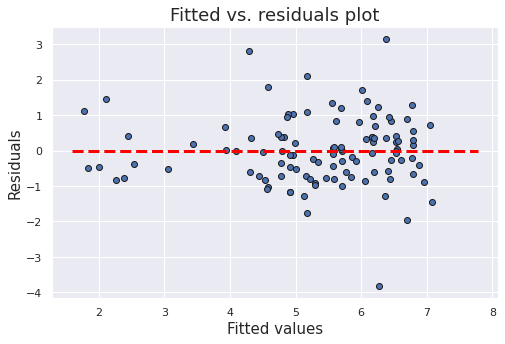

In [26]:
plt.figure(figsize=(8,5))
p=plt.scatter(x=res.fittedvalues,y=res.resid_pearson,edgecolor='k')
xmin=min(res.fittedvalues)
xmax = max(res.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

An inspection of the fitted vs residual values above suggests uniform variance.

**Using Scikit-Learn (using LinearRegression)**

Below we try out the Scikit-Learn implementation in order to compare.

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder

from sklearn2pmml import sklearn2pmml
from sklearn_pandas import DataFrameMapper
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml.decoration import ContinuousDomain

X = fishes.filter(items=['Length3','Species'])
y = fishes['Weight']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

mapper = DataFrameMapper([
    (['Length3'], [ContinuousDomain(), FunctionTransformer(np.log)]),
    (['Species'], [OneHotEncoder()])
])

model_pipeline = PMMLPipeline([
    ("mapper", mapper),
    ("model", TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp))
])


clf = model_pipeline.fit(X_train, y_train);

#Need to Java installed for the line below to run.
#sklearn2pmml(clf, 'fish-weight-model.pmml', with_repr=True, debug=True)

*Test Set Performance*

In [ ]:
# Make predictions using the testing set
y_pred = clf.predict(X_test)

In [ ]:
print('Coefficient of determination: %.3f' % r2_score(y_test, y_pred))

In [ ]:
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

# Conclusion

Linear regression performed with an r2 score of `0.975` on the test set while fairly well satisfying the assumptions of an OLS estimator.

# References

* https://online.stat.psu.edu/stat462/node/116/
* https://towardsdatascience.com/how-do-you-check-the-quality-of-your-regression-model-in-python-fa61759ff685